# Usage Example of `Gensys.jl`

To demonstrate the usage of `Gensys.jl`,  we will describe a simple economic model, explain how to cast it into the form required by the package, and then show how to find the solution numerically.

## Model 
Consider the simple real-business cycle model:

$$\max \mathbb{E} \displaystyle \sum_{t=1}^{\infty} \beta^t \log C_t$$

subject to

\begin{align}
Y_t &= Z_t K_{t-1}^{\alpha} \\
\log Z_t &= \psi \log Z_{t-1} + \varepsilon_{Zt} \\
C_t + K_t &= Y_t + (1 - \delta)K_{t-1}
\end{align}

where $\varepsilon_{Zt} \sim \mathcal{N}(0, \sigma^2_z)$.

The first-order conditions are:

\begin{align}
1 &= \beta \mathbb{E}_t \left[\frac{C_t}{C_{t+1}} R_{t+1} \right] \\
R_t &= \alpha \frac{Y_t}{K_{t-1}} + 1 - \delta
\end{align}

The first-order conditions and the constraints define the equilibrium conditions of the problem. However, these cannot be solved in closed-form. Instead, we will approximate them by linear expectational difference equations, then solve this approximation of the model using `Gensys.jl`.

To construct a log-linear approximation, we will need to know the steady state values of the variables. In this example they can be found in closed form. By setting $(Y_t, K_t, Z_t, C_t, R_t) = (\bar{Y}, \bar{K}, \bar{Z}, \bar{C}, \bar{R})$ and $\varepsilon_{Zt} = 0$ in the equilibrium conditions above, we will find:

\begin{align}
\bar{Y} &= \bar{K}^{\alpha} \\
\bar{K} &= \left( \frac{\alpha}{\bar{R} - 1 + \delta} \right) ^{\frac{1}{1-\alpha}} \\
\bar{Z} &= 1 \\
\bar{C} &= \bar{Y} - \delta \bar{K} \\
\bar{R} &= \frac{1}{\beta}
\end{align}

The linearized versions of the equilibrium conditions are as follows:

\begin{align}
y_t &= z_t + \alpha k_{t-1} \\
k_t &= \frac{\bar{Y}}{\bar{K}} y_t - \frac{\bar{C}}{\bar{K}} c_t + (1-\delta) k_{t-1} \\
z_t &= \psi z_{t-1} + \varepsilon_{Zt} \\
c_t &= \mathbb{E}_t[c_{t+1} - r_{t+1}] \\
r_t &= \frac{\alpha \bar{Y}}{\bar{R} \bar{K}} (y_t - k_{t-1})
\end{align}

Here, lowercase letters represent log deviations from steady state.

## Gensys Form

The canonical form of the model assumed by Gensys is the following (with some slight abuses of notation with respect to the variables defined above):

$$\Gamma_0 x_t = \Gamma_1 x_{t-1} + c + \Psi z_t + \Pi \eta_t$$

Here, $x_t$ is an $n \times 1$ vector of endogenous variables, $z_t$ is a $k \times 1$ vector of exogenous shocks, and $\Gamma_0, \Gamma_1, \Psi, $ and $\Pi$ are $n \times n$, $n \times n$, $n \times k$, and $n \times r$, respectively, coefficient matrices. $c$ is an $n \times 1$ vector of constants. $\eta_t$ is an $r \times 1$ vector of expectational errors. These are the deviations of variables from last period's expected value, defined as $\eta_t = x_t - \mathbb{E}_{t-1}(x_t)$. They are assumed to satisfy $\mathbb{E}_t[\eta_{t+1}]=0$.

We are now ready to put our model into this form by stacking the linearized versions of the equilibrium conditions. Define our vectors as:

\begin{align}
x_t &=
\begin{pmatrix}
y_t & k_t & z_t & c_t & r_t & \mathbb{E}_t[c_{t+1}] & \mathbb{E}_t[r_{t+1}]
\end{pmatrix}' \\
z_t &= \varepsilon_{Zt} \\
x_t &=
\begin{pmatrix}
c_t - \mathbb{E}_{t-1}[c_t] & r_t - \mathbb{E}_{t-1}[r_t]]
\end{pmatrix}'
\end{align}

The coefficient matrices are:

$$
\Gamma_0 =
\begin{pmatrix}
1 & 0 & -1 & 0 & 0 & 0 & 0 \\
-\frac{\bar{Y}}{\bar{K}} & 1 & 0 & \frac{\bar{C}}{\bar{K}} & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & -1 & 1 \\
-\frac{\alpha \bar{Y}}{\bar{R} \bar{K}} & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
\end{pmatrix}
$$

$$
\Gamma_1 =
\begin{pmatrix}
0 & \alpha & 0 & 0 & 0 & 0 & 0 \\
0 & 1 - \delta & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \psi & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & -\frac{\alpha \bar{Y}}{\bar{R} \bar{K}} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

$$
\Psi =
\begin{pmatrix}
0 \\
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
\end{pmatrix}
$$

$$
\Pi =
\begin{pmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1 \\
\end{pmatrix}
$$

Note that the two extra equations are needed to define the expectational errors. Therefore, here we have $n=7$ equations, $k=1$ exogenous shocks, and $r=2$ expectational errors.

## Numerical Implementation

The solution to the canonical model takes the following form:

$$y_t = \Theta y_{t-1} + \Phi z_t + \displaystyle \sum_{s=0}^{\infty} AM^SB \mathbb{E}_t [z_{t+s+1}]$$

The matrices $\Theta, \Phi, A, M, $ and $B$ will be returned by the package, given the coefficient matrices $\Gamma_0, \Gamma_1, \Psi, $ and $\Pi$. To demonstrate, let's first set these up.

In [2]:
include("src/gensys.jl")
using Gensys
using Plots
pyplot()

# Set values for the parameters
alpha = 1/3
beta = 0.97
delta = 0.08
psi = 0.95
sigma_Z = 0.007

# Function that returns steady state values given parameters
function steady_states(alpha::Float64, beta::Float64, delta::Float64)
    R = 1 / beta
    K = (alpha / (R - 1 + delta))^(1 / (1-alpha))
    Y = K^alpha
    C = Y - delta*K
    return R, K, Y, C
end

R, K, Y, C = steady_states(alpha, beta, delta)

# Set up coefficient matrices
Gamma0 = [1 0 -1 0 0 0 0;
          -Y/K 1 0 C/K 0 0 0;
          0 0 1 0 0 0 0;
          0 0 0 1 0 -1 1;
          -(alpha*Y)/(R*K) 0 0 0 1 0 0;
          0 0 0 1 0 0 0;
          0 0 0 0 1 0 0]

Gamma1 = [0 alpha 0 0 0 0 0;
          0 1-delta 0 0 0 0 0;
          0 0 psi 0 0 0 0;
          0 0 0 0 0 0 0;
          0 -(alpha*Y)/(R*K) 0 0 0 0 0;
          0 0 0 0 0 1 0;
          0 0 0 0 0 0 1]

Psi = [0; 0; 1; 0; 0; 0; 0]

Pi = [0 0; 0 0; 0 0; 0 0; 0 0; 1 0; 0 1];

c = zeros(7, 1);

To get the matrices that characterize the solution, we just need to call the function `gensysdt` (for the discrete-time version of the Gensys algorithm). This function takes the coefficient matrices, `Gamma0`, `Gamma1`, `Psi`, and `Pi`, plus an additional vector `c` of constant terms, which in our case is all zeros.

In [3]:
G1, Const, impact, fmat, fwt, ywt, gev, eu, loose = Gensys.gensysdt(Gamma0, Gamma1, c, Psi, Pi);

Because in our case the shocks $(z_t = \varepsilon_{Zt})$ are i.i.d., the last term in the solution drops out. Therefore, in order to simulate the model, we just need `G1` and `impact`, which correspond to $\Phi$ and $\Theta$, respectively.

In [19]:
# Simulation

T = 1000
u = randn(T+1)*sigma_Z;
x = zeros(7, T+1)

for t=1:T
    x[:, t+1] = G1*x[:, t] + impact*u[t+1]
end


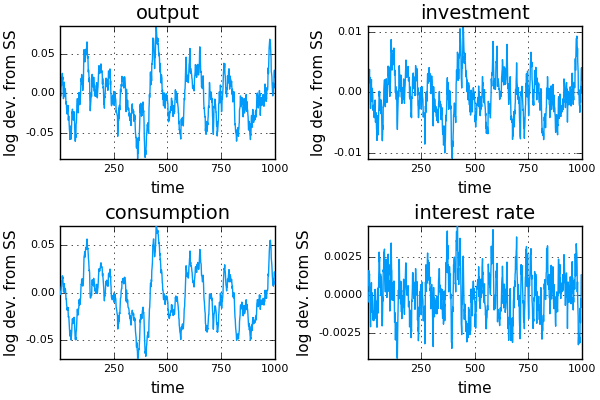

In [20]:
output = x[1, :]'
investment = x[2, 2:end]' - (1-delta)*x[2, 1:end-1]'
consumption = x[4, :]'
interest_rate = x[5, :]'

# Plot simulated values
plot([output[2:end] investment consumption[2:end] interest_rate[2:end]], 
     layout=(2,2), title=["output" "investment" "consumption" "interest rate"],
     legend=:none, xlabel="time", ylabel="log dev. from SS")